In [131]:
import os
import skimage
import argparse
import cv2 as cv
import numpy as np
from pathlib import Path
from numpy import ndarray
import matplotlib.pyplot as plt

In [132]:
def display_image(title, img):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

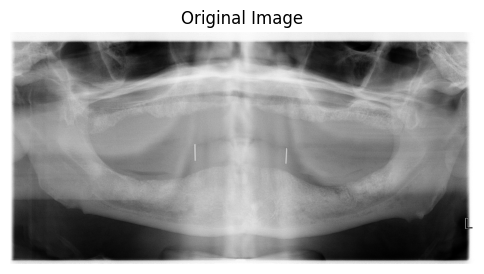

In [133]:
img = cv.imread('../../forvin/measure/1006657.tiff', cv.IMREAD_GRAYSCALE)
if img is None:
    print("Error: Image not found. Please check the file path.")
else:
    display_image("Original Image", img)


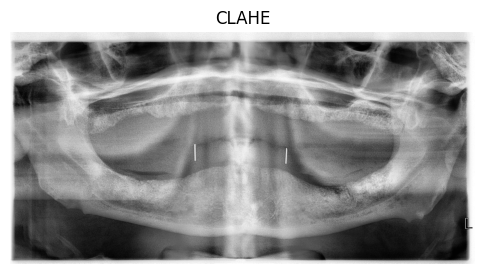

In [134]:
clahe = skimage.exposure.equalize_adapthist(img)
display_image("CLAHE", clahe)

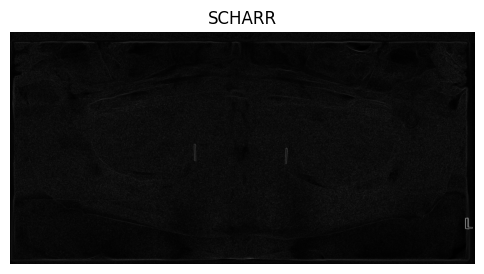

In [135]:
def scharr_edge_detection(img: ndarray) -> ndarray:
    scharr = skimage.filters.scharr(img)
    return skimage.exposure.rescale_intensity(scharr, in_range="image")
scharr = scharr_edge_detection(clahe)
display_image("SCHARR", scharr)

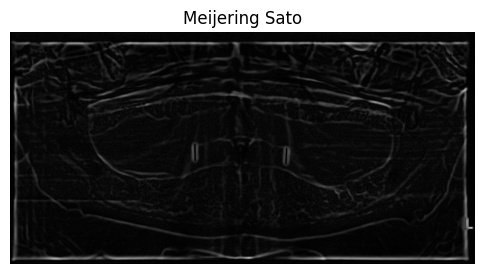

In [136]:
def meijering_sato_ridge_filter(img: ndarray) -> ndarray:
    meijering = skimage.filters.meijering(img)
    sato = skimage.filters.sato(img)
    return skimage.exposure.rescale_intensity(sato + meijering, in_range="image")
meijering_sato = meijering_sato_ridge_filter(clahe)
display_image("Meijering Sato", meijering_sato)

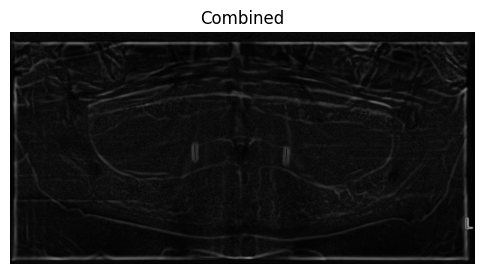

In [137]:
combined = skimage.exposure.rescale_intensity(
            scharr + meijering_sato, in_range="image"
        )
display_image("Combined", combined)

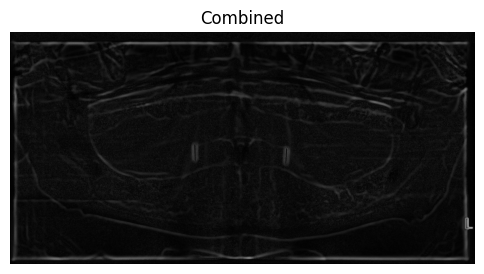

In [138]:
combined = skimage.util.img_as_ubyte(combined)
display_image("Combined", combined)

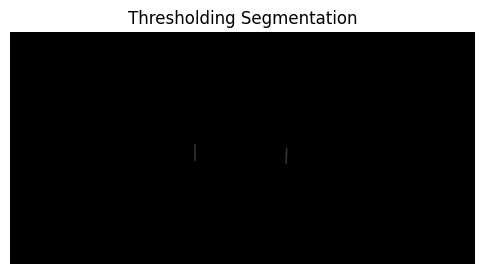

In [139]:
def thresholding_segmentation_3(img: ndarray):
    img_copy = img.copy()
    height, width = img_copy.shape

    footprint = skimage.morphology.disk(100)
    img_copy = skimage.filters.rank.threshold(img_copy, footprint=footprint)
    img_copy = ~img_copy
    img_copy = skimage.exposure.rescale_intensity(img_copy, in_range="image")

    contours = skimage.measure.find_contours(img_copy, 2)
    for contour in contours:
        x, y = contour[:, 1], contour[:, 0]
        min_x, max_x = int(np.ceil(np.min(x))), int(np.ceil(np.max(x)))
        min_y, max_y = int(np.ceil(np.min(y))), int(np.ceil(np.max(y)))

        if max_x - min_x > max_y - min_y:
            continue

        if max_y - min_y < 50:
            continue

        if min_x < img.shape[1] * 0.3 or min_x > img.shape[1] * 0.75:
            continue

        if min_y < img.shape[0] * 0.25 or max_y > img.shape[0] * 0.85:
            continue

        for _x, _y in zip(x, y):
            __x, __y = int(np.ceil(_x)), int(np.ceil(_y))

            img_copy[__y, __x] = 127

        img_copy[img_copy == 255] = 0

        for _y in y:
            __y = int(np.ceil(_y))
            arg = np.argwhere(y == _y)
            _x = x.flatten()
            _x = x[arg]
            __min_x, __max_x = int(np.ceil(np.min(_x))), int(np.ceil(np.max(_x)))

            if __max_x - __min_x > 20:
                for _x, _y in zip(x, y):
                    __x, __y = int(np.ceil(_x)), int(np.ceil(_y))

                    img_copy[__y, __x] = 0

    img_copy[img_copy == 127] = 255

    return img_copy

_thresholding_segmentation_3 = thresholding_segmentation_3(combined)
display_image("Thresholding Segmentation", _thresholding_segmentation_3)

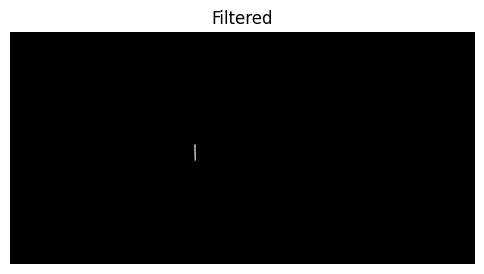

In [149]:
def filter(image, contours):
    filtered_image = np.zeros_like(image)
    
    for contour in contours:
        area = cv.contourArea(contour)
        if area < 600:
            continue
        
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = w / h
        
        if aspect_ratio < 0.3:
            cv.drawContours(filtered_image, [contour], -1, 255, thickness=cv.FILLED)
    
    return filtered_image

contours, _ = cv.findContours(_thresholding_segmentation_3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
filterimg = filter(_thresholding_segmentation_3, contours)
display_image("Filtered", filterimg)